In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gym
import sys
import itertools

from collections import defaultdict
from collections import namedtuple

# Initialize Environment

In [2]:
env = gym.make('WindyGridWorldEnv-v0')
env.reset()

(3, 0)

# Define Functions

## Function: make_epsilon_greedy_policy

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
           Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action (float between 0 and 1).
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype = float) * epsilon / nA 
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

## Function: plot_episode_stats

In [4]:
def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    """
    Plots episode stats.
    
    Args:
        stats: stats object of type namedTuple
        smoothing_windows: Smoothing parameter for plotting rewards
        noshow: Boolean. True -> Show plots; False -> Don't show plots.
    
    Returns:
        fig1: Figure object showing 'Episode Length over time'
        fig2: Figure object showing 'Episode Reward over time'
        fig3: Figure object showing 'Episodes per time step'
    """    
    
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

    return fig1, fig2, fig3

## Function: sarsa

In [5]:
def sarsa(env, num_episodes, discount_factor = 1.0, alpha = 0.5, epsilon = 0.1):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])
    stats = EpisodeStats(episode_lengths = np.zeros(num_episodes), episode_rewards = np.zeros(num_episodes))

    # Define the policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p = action_probs)
        
        # Loop for each episode
        for t in itertools.count():
            # Take a step
            next_state, reward, done, _ = env.step(action)
            
            # Pick the next action
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p = next_action_probs)
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Perform TD Update
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
            
            if done:
                break
                
            action = next_action
            state = next_state        
    
    return Q, stats

## Function: plot_trajectory

In [6]:
def plot_trajectory(Q, env):
    """
    Displays episode trajectory using greedy policy for a given action value function.
    
    Args:
        Q: action value function
        env: Environment Instance
     """      
    
    
    # Obtain action code to action mapping
    env_action_map = dict()
    for key, value in env.actions.items():
        env_action_map[value] = key 
    
    env.reset()
    while (1):
        state = env.observation        
        action = np.argmax(Q[state])
        print(state, ' -> ', env_action_map[action])        
        next_state, _, done, _ = env.step(action)
        if done:
            print(next_state, ' -> ', 'Terminal')
            break

# Run Sarsa and plot statistics

Episode 1000/1000.

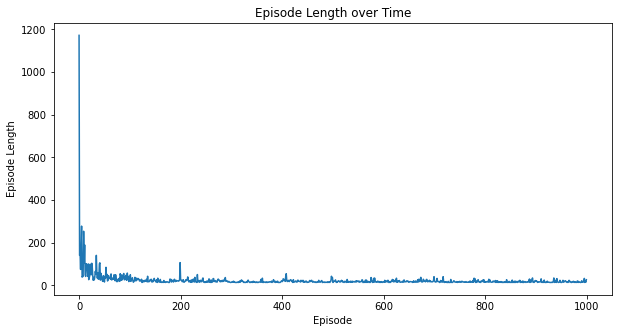

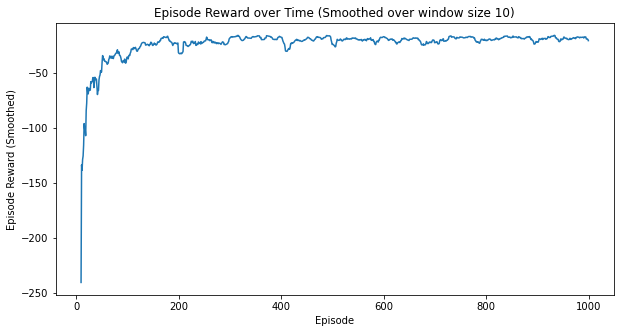

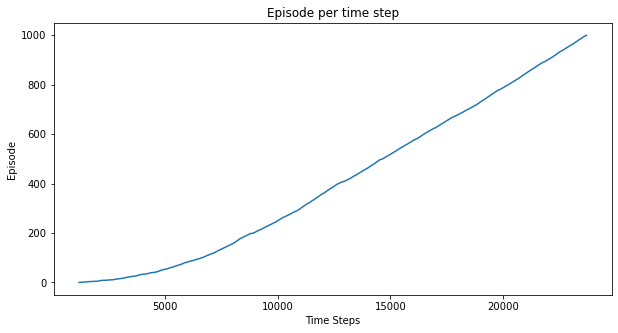

In [7]:
Q, stats = sarsa(env, 1000)
fig1, fig2, fig3 = plot_episode_stats(stats)

# Plot trajectory of final action value function

In [8]:
plot_trajectory(Q, env)

(3, 0)  ->  R
(3, 1)  ->  R
(3, 2)  ->  R
(3, 3)  ->  U
(1, 3)  ->  R
(0, 4)  ->  R
(0, 5)  ->  R
(0, 6)  ->  R
(0, 7)  ->  R
(0, 8)  ->  R
(0, 9)  ->  D
(1, 9)  ->  D
(2, 9)  ->  D
(3, 9)  ->  D
(4, 9)  ->  L
(4, 8)  ->  L
(3, 7)  ->  Terminal
